In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.8.5


### Construção de um modelo de Rede Neural com programação e matemática

In [2]:
# Instala o pacote watermark. 
!pip install -q -U watermark

In [3]:
# Imports dos pacotes
import numpy as np
import sklearn
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [4]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Rodrigo Abreu" --iversions

Author: Rodrigo Abreu

pandas    : 1.1.3
sklearn   : 0.23.2
numpy     : 1.19.2
matplotlib: 3.3.2



#### Desenvolvendo a Função Para Inicialização de Pesos

In [5]:
# Função para inicialização randômica dos parâmetros do modelo
def inicializa_parametros(dims_camada_entrada):
    
    # Dicionário para os parâmetros
    parameters = {}
    
    # Comprimento das dimensões das camadas
    comp = len(dims_camada_entrada)
    
    # Loop pelo comprimento
    for i in range(1, comp):
        
        # Inicialização da matriz de pesos
        parameters["W" + str(i)] = np.random.randn(dims_camada_entrada[i], dims_camada_entrada[i - 1]) * 0.01
        
        # Inicialização do bias
        parameters["b" + str(i)] = np.zeros((dims_camada_entrada[i], 1))
    
    return parameters

In [6]:
# Função sigmóide
def sigmoid(Z):
    A = 1 / (1 + np.exp(-Z))
    return A, Z

In [7]:
# Função de ativação ReLu (Rectified Linear Unit)
def relu(Z):
    A = abs(Z * (Z > 0))
    return A, Z

In [8]:
# Operação de ativação
# A é a matriz com os dados de entrada
# W é a matriz de pesos
# b é o bias
def linear_activation(A, W, b):
    Z = np.dot(W, A) + b
    cache = (A, W, b)
    return Z, cache

In [9]:
# Movimento para frente (forward)
def forward(A_prev, W, b, activation):
    
    # Se a função de ativação for Sigmoid, entramos neste bloco
    if activation == "sigmoid":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = sigmoid(Z)
        
    # Se não, se for ReLu, entramos neste bloco    
    elif activation == "relu":
        Z, linear_cache = linear_activation(A_prev, W, b)
        A, activation_cache = relu(Z)
        
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [10]:
# Propagação para frente
def forward_propagation(X, parameters):
    
    # Lista de valores anteriores (cache)
    caches = []
    
    # Dados de entrada
    A = X
    
    # Comprimento dos parâmetros
    L = len(parameters) // 2
   
    # Loop
    for i in range(1, L):
      
        # Guarda o valor prévio de A
        A_prev = A
        
        # Executa o forward
        A, cache = forward(A_prev, parameters["W" + str(i)], parameters["b" + str(i)], activation = "relu")
        
        # Grava o cache
        caches.append(cache)
    
    # Saída na última camada
    A_last, cache = forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "sigmoid")
    
    # Grava o cache
    caches.append(cache)
    
    return(A_last, caches)

In [11]:
# Função de custo (ou função de erro)
def calcula_custo(A_last, Y):
    
    # Ajusta o shape de Y para obter seu comprimento (total de elementos)
    m = Y.shape[1]
    
    # Calcula o custo comparando valor real e previso
    custo = (-1 / m) * np.sum((Y * np.log(A_last)) + ((1 - Y) * np.log(1 - A_last)))
    
    # Ajusta o shape do custo
    custo = np.squeeze(custo)
    
    return(custo)

In [12]:
# Função sigmoid para o backpropagation 
# Fazemos o cálculo da derivada pois não queremos o valor completo da função, mas sim sua variação
def sigmoid_backward(da, Z):
    
    # Calculamos a derivada de Z
    dg = (1 / (1 + np.exp(-Z))) * (1 - (1 / (1 + np.exp(-Z))))
    
    # Encontramos a mudança na derivada de z
    dz = da * dg
    return dz

In [13]:
# Função relu para o backpropagation 
# Fazemos o cálculo da derivada pois não queremos o valor completo da função, mas sim sua variação
def relu_backward(da, Z):
    
    dg = 1 * ( Z >= 0)
    dz = da * dg
    return dz

In [14]:
# Ativação linear para o backpropagation
def linear_backward_function(dz, cache):
    
    # Recebe os valores do cache (memória)
    A_prev, W, b = cache
    
    # Shape de m
    m = A_prev.shape[1]
    
    # Calcula a derivada de W (resultado da operação com dz)
    dW = (1 / m) * np.dot(dz, A_prev.T)
    
    # Calcula a derivada de b (resultado da operação com dz)
    db = (1 / m) * np.sum(dz, axis = 1, keepdims = True)
    
    # Calcula a derivada da operação
    dA_prev = np.dot(W.T, dz)
    
    return dA_prev, dW, db

In [15]:
# Função que define o tipo de ativação (relu ou sigmoid)
def linear_activation_backward(dA, cache, activation):
    
    # Extrai o cache
    linear_cache, activation_cache = cache
    
    # Verifica se a ativação é relu
    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    # Verifica se a ativação é sigmoid
    if activation == "sigmoid":
        dZ = sigmoid_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward_function(dZ, linear_cache)
        
    return dA_prev, dW, db

In [16]:
# Algoritmo Backpropagation (calcula os gradientes para atualização dos pesos)
# AL = Valor previsto no Forward
# Y = Valor real
def backward_propagation(AL, Y, caches):
    
    # Dicionário para os gradientes
    grads = {}
    
    # Comprimento dos dados (que estão no cache)
    L = len(caches)
    
    # Extrai o comprimento para o valor de m
    m = AL.shape[1]
    
    # Ajusta o shape de Y
    Y = Y.reshape(AL.shape)
    
    # Calcula a derivada da previsão final da rede (feita ao final do Forward Propagation)
    dAL = -((Y / AL) - ((1 - Y) / (1 - AL)))
    
    # Captura o valor corrente do cache
    current_cache = caches[L - 1]
    
    # Gera a lista de gradiente para os dados, os pesos e o bias
    # Fazemos isso uma vez, pois estamos na parte final da rede, iniciando o caminho de volta
    grads["dA" + str(L - 1)], grads["dW" + str(L)], grads["db" + str(L)] = linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
    # Loop para calcular a derivada durante as ativações lineares com a relu
    for l in reversed(range(L - 1)):
        
        # Cache atual
        current_cache = caches[l]
        
        # Calcula as derivadas
        dA_prev, dW, db = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation = "relu")
        
        # Alimenta os gradientes na lista, usando o índice respectivo
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW
        grads["db" + str(l + 1)] = db
        
    return grads

In [17]:
# Função de atualização de pesos
def atualiza_pesos(parameters, grads, learning_rate):
    
    # Comprimento da estrutura de dados com os parâmetros (pesos e bias)
    L = len(parameters)//2
    
    # Loop para atualização dos pesos
    for l in range(L):
        
        # Atualização dos pesos
        parameters["W" + str(l + 1)] = parameters["W" + str(l + 1)] - (learning_rate * grads["dW" + str(l + 1)])
        
        # Atualização do bias
        parameters["b" + str(l + 1)] = parameters["b" + str(l + 1)] - (learning_rate * grads["db" + str(l + 1)])
    
    return parameters

In [52]:
# Modelo completo da rede neural
def modeloNN(X, Y, dims_camada_entrada, learning_rate = 0.0075, num_iterations = 100):
    
    # Lista para receber o custo a cada época de treinamento
    custos = []
    
    # Inicializa os parâmetros
    parametros = inicializa_parametros(dims_camada_entrada)
    
    # Loop pelo número de iterações (épocas)
    for i in range(num_iterations):
        
        # Forward Propagation
        AL, caches = forward_propagation(X, parametros)
        
        # Calcula o custo
        custo = calcula_custo(AL, Y)
        
        # Backward Propagation
        gradientes = backward_propagation(AL, Y, caches)
        
        # Atualiza os pesos
        parametros = atualiza_pesos(parametros, gradientes, learning_rate)
        
        # Print do valor intermediário do custo
        # A redução do custo indica o aprendizado do modelo
        if i % 10 == 0:
            print("Custo Após " + str(i) + " iterações é " + str(custo))
            custos.append(custo)
            
    return parametros, custos 

In [19]:
# Função para fazer as previsões
def predict(X, parametros):
    AL, caches = forward_propagation(X, parametros)
    return AL

#### Usando a Rede Neural Para Prever a Ocorrência de Câncer

In [20]:
#Carregando os Dados
#https://scikit-learn.org/stable/datasets/index.html#breast-cancer-dataset

In [21]:
# Carregamos o objeto completo
temp = load_breast_cancer()

In [22]:
# Tipo do objeto
type(temp)

sklearn.utils.Bunch

In [23]:
# Visualiza o objeto
temp

{'data': array([[1.799e+01, 1.038e+01, 1.228e+02, ..., 2.654e-01, 4.601e-01,
         1.189e-01],
        [2.057e+01, 1.777e+01, 1.329e+02, ..., 1.860e-01, 2.750e-01,
         8.902e-02],
        [1.969e+01, 2.125e+01, 1.300e+02, ..., 2.430e-01, 3.613e-01,
         8.758e-02],
        ...,
        [1.660e+01, 2.808e+01, 1.083e+02, ..., 1.418e-01, 2.218e-01,
         7.820e-02],
        [2.060e+01, 2.933e+01, 1.401e+02, ..., 2.650e-01, 4.087e-01,
         1.240e-01],
        [7.760e+00, 2.454e+01, 4.792e+01, ..., 0.000e+00, 2.871e-01,
         7.039e-02]]),
 'target': array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
        1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
        1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0

In [24]:
# Carregamos o dataset
dados = pd.DataFrame(columns = load_breast_cancer()["feature_names"], data = load_breast_cancer()["data"])

In [25]:
# Shape
dados.shape

(569, 30)

In [26]:
# Visualiza os dados
dados.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [30]:
# Verifica se temos valores ausentes
dados.isnull().any()

mean radius                False
mean texture               False
mean perimeter             False
mean area                  False
mean smoothness            False
mean compactness           False
mean concavity             False
mean concave points        False
mean symmetry              False
mean fractal dimension     False
radius error               False
texture error              False
perimeter error            False
area error                 False
smoothness error           False
compactness error          False
concavity error            False
concave points error       False
symmetry error             False
fractal dimension error    False
worst radius               False
worst texture              False
worst perimeter            False
worst area                 False
worst smoothness           False
worst compactness          False
worst concavity            False
worst concave points       False
worst symmetry             False
worst fractal dimension    False
dtype: boo

In [31]:
# Separa a variável target
target = load_breast_cancer()["target"]

In [32]:
type(target)

numpy.ndarray

In [33]:
# Visualiza a variável
target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0,
       1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0,

In [34]:
# Total de registros por classe - Câncer Benigno
np.count_nonzero(target == 1)

357

In [35]:
# Total de registros por classe - Câncer Maligno
np.count_nonzero(target == 0)

212

In [36]:
# Nomes das classes da variável target
target_names = load_breast_cancer()["target_names"]

In [37]:
target_names

array(['malignant', 'benign'], dtype='<U9')

In [41]:
# Extrair os labels

# Dicionário para os labels
labels = {}

# Mapeamento
for i in range(len(target_names)):
    labels.update({i:target_names[i]})

In [42]:
# Visualiza os labels
labels

{0: 'malignant', 1: 'benign'}

In [43]:
# Agora preparamos as variáveis preditoras em X
X = np.array(dados)

In [44]:
# Dividimos os dados de entrada e saída em treino e teste
X_treino, X_teste, y_treino, y_teste = train_test_split(X, target, test_size = 0.15, shuffle = True)

In [45]:
# Shape dos dados de treino
print(X_treino.shape)
print(y_treino.shape)

(483, 30)
(483,)


In [46]:
# Ajusta o shape dos dados de entrada
X_treino = X_treino.T
X_teste = X_teste.T

In [47]:
print(X_treino.shape)
print(X_teste.shape)

(30, 483)
(30, 86)


In [48]:
# Precisamos ajustar também os dados de saída
y_treino = y_treino.reshape(1, len(y_treino))
y_teste = y_teste.reshape(1, len(y_teste))

In [49]:
print(y_treino.shape)
print(y_teste.shape)

(1, 483)
(1, 86)


In [50]:
# Variável com as dimensões de entrada para o número de neurônios 
dims_camada_entrada = [X_treino.shape[0], 50, 20, 5, 1]

In [53]:
# Treinamento do modelo

print("\nIniciando o Treinamento.\n")

parametros, custo = modeloNN(X = X_treino, 
                             Y = y_treino, 
                             dims_camada_entrada = dims_camada_entrada, 
                             num_iterations = 3000, 
                             learning_rate = 0.0075)

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento.

Custo Após 0 iterações é 0.6931403612710852
Custo Após 10 iterações é 0.6922320846114421
Custo Após 20 iterações é 0.6913579481239872
Custo Após 30 iterações é 0.690516035818632
Custo Após 40 iterações é 0.6897049514873573
Custo Após 50 iterações é 0.6889234708365608
Custo Após 60 iterações é 0.6881704585017931
Custo Após 70 iterações é 0.6874448192867983
Custo Após 80 iterações é 0.6867455080178212
Custo Após 90 iterações é 0.6860715211833015
Custo Após 100 iterações é 0.6854218976088503
Custo Após 110 iterações é 0.6847958277284057
Custo Após 120 iterações é 0.6841936760515682
Custo Após 130 iterações é 0.6836134955550186
Custo Após 140 iterações é 0.6830543418705953
Custo Após 150 iterações é 0.6825153944724133
Custo Após 160 iterações é 0.6819958734471148
Custo Após 170 iterações é 0.6814950277658189
Custo Após 180 iterações é 0.681012122609631
Custo Após 190 iterações é 0.68054644948781
Custo Após 200 iterações é 0.6800973203457263
Custo Após 210 iteraçõ

Custo Após 1750 iterações é 0.2777562784665194
Custo Após 1760 iterações é 0.27629531195384616
Custo Após 1770 iterações é 0.2771516281277458
Custo Após 1780 iterações é 0.2755453346082695
Custo Após 1790 iterações é 0.2742710559623301
Custo Após 1800 iterações é 0.2756171300066129
Custo Após 1810 iterações é 0.27592198432960185
Custo Após 1820 iterações é 0.2671924627958935
Custo Após 1830 iterações é 0.26149820381679845
Custo Após 1840 iterações é 0.2595356870175787
Custo Após 1850 iterações é 0.25855247886820143
Custo Após 1860 iterações é 0.2589751519632969
Custo Após 1870 iterações é 0.2609327369084812
Custo Após 1880 iterações é 0.2632871731375996
Custo Após 1890 iterações é 0.26681511548253334
Custo Após 1900 iterações é 0.2756365498389472
Custo Após 1910 iterações é 0.27161041831605964
Custo Após 1920 iterações é 0.26570194749678616
Custo Após 1930 iterações é 0.27087799803281454
Custo Após 1940 iterações é 0.2670303289148116
Custo Após 1950 iterações é 0.2638444832200825
Custo

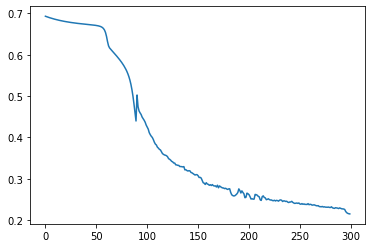

In [54]:
plt.plot(custo)

In [55]:
# Treinamento do modelo

print("\nIniciando o Treinamento.\n")

parametros, custo = modeloNN(X = X_treino, 
                             Y = y_treino, 
                             dims_camada_entrada = dims_camada_entrada, 
                             num_iterations = 4000, 
                             learning_rate = 0.0075)

print("\nTreinamento Concluído.\n")


Iniciando o Treinamento.

Custo Após 0 iterações é 0.693128705745188
Custo Após 10 iterações é 0.6922220577708078
Custo Após 20 iterações é 0.6913487735671733
Custo Após 30 iterações é 0.6905075582782587
Custo Após 40 iterações é 0.6896971688144793
Custo Após 50 iterações é 0.6889164441468038
Custo Após 60 iterações é 0.6881642698776876
Custo Após 70 iterações é 0.6874395658851584
Custo Após 80 iterações é 0.6867412900045867
Custo Após 90 iterações é 0.6860684468899257
Custo Após 100 iterações é 0.6854200687031191
Custo Após 110 iterações é 0.6847952209498234
Custo Após 120 iterações é 0.6841930055100109
Custo Após 130 iterações é 0.6836125540857074
Custo Após 140 iterações é 0.6830530270216254
Custo Após 150 iterações é 0.6825135880003887
Custo Após 160 iterações é 0.6819934566125839
Custo Após 170 iterações é 0.6814917902829023
Custo Após 180 iterações é 0.68100685124195
Custo Após 190 iterações é 0.6805347068651322
Custo Após 200 iterações é 0.6800768866519802
Custo Após 210 iteraç

Custo Após 1990 iterações é 0.2533070185969426
Custo Após 2000 iterações é 0.2565396218130722
Custo Após 2010 iterações é 0.25490631160352334
Custo Após 2020 iterações é 0.2537833250574708
Custo Após 2030 iterações é 0.2533755046798181
Custo Após 2040 iterações é 0.25305533058668966
Custo Após 2050 iterações é 0.25257604784017934
Custo Após 2060 iterações é 0.2514574699629279
Custo Após 2070 iterações é 0.25275191273011094
Custo Após 2080 iterações é 0.253172873180521
Custo Após 2090 iterações é 0.2524695918659313
Custo Após 2100 iterações é 0.251170760876603
Custo Após 2110 iterações é 0.25086272262345727
Custo Após 2120 iterações é 0.2514518597034022
Custo Após 2130 iterações é 0.2478138417327781
Custo Após 2140 iterações é 0.24169602298065496
Custo Após 2150 iterações é 0.2410285384347768
Custo Após 2160 iterações é 0.24181159409313938
Custo Após 2170 iterações é 0.2420713519821428
Custo Após 2180 iterações é 0.24723468288612396
Custo Após 2190 iterações é 0.2478620428370099
Custo A

Custo Após 3900 iterações é 0.20533084960979248
Custo Após 3910 iterações é 0.20433281716658008
Custo Após 3920 iterações é 0.2038879160814171
Custo Após 3930 iterações é 0.20407563607274742
Custo Após 3940 iterações é 0.2033153449172935
Custo Após 3950 iterações é 0.20429832360479974
Custo Após 3960 iterações é 0.20438456062723512
Custo Após 3970 iterações é 0.20443579390173702
Custo Após 3980 iterações é 0.20344952923224216
Custo Após 3990 iterações é 0.2039722724386988

Treinamento Concluído.



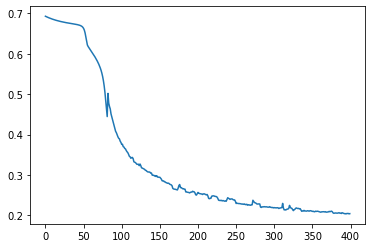

In [56]:
plt.plot(custo)

In [58]:
# Previsões com os dados de treino
y_pred_treino = predict(X_treino, parametros)

In [59]:
# Visualiza as previsões
y_pred_treino

array([[2.80306952e-02, 8.96885777e-01, 7.01027116e-01, 8.59117714e-01,
        1.73506067e-08, 7.25596730e-01, 6.35316968e-01, 4.11326761e-10,
        6.42982293e-02, 3.03348276e-01, 8.00277917e-01, 1.58663994e-02,
        9.64148862e-11, 8.28565785e-01, 8.88459600e-01, 7.81368204e-01,
        6.66577471e-06, 8.55624773e-01, 1.79763900e-08, 9.08213339e-01,
        1.45542980e-07, 8.90697039e-01, 9.10450994e-01, 2.97070941e-02,
        9.05354693e-01, 3.18761604e-19, 9.10450874e-01, 9.10451073e-01,
        1.86921914e-04, 7.25755533e-06, 2.78201492e-01, 9.10451091e-01,
        3.98267019e-02, 8.82188895e-01, 9.10451056e-01, 7.19253284e-01,
        7.71261815e-01, 6.07066169e-01, 6.45613649e-01, 9.10450898e-01,
        7.05743415e-13, 4.09410953e-01, 8.88582396e-01, 7.85369694e-01,
        4.29137159e-04, 3.07520103e-06, 9.10451091e-01, 1.31332053e-01,
        4.42770645e-03, 9.10442108e-01, 9.10450942e-01, 6.15757753e-01,
        8.95176621e-01, 1.55111725e-03, 9.10450916e-01, 1.044736

In [60]:
# Ajustamos o shape em treino
y_pred_treino = y_pred_treino.reshape(-1)
y_treino = y_treino.reshape(-1)

In [61]:
y_pred_treino > 0.5

array([False,  True,  True,  True, False,  True,  True, False, False,
       False,  True, False, False,  True,  True,  True, False,  True,
       False,  True, False,  True,  True, False,  True, False,  True,
        True, False, False, False,  True, False,  True,  True,  True,
        True,  True,  True,  True, False, False,  True,  True, False,
       False,  True, False, False,  True,  True,  True,  True, False,
        True, False,  True,  True, False,  True,  True, False, False,
       False,  True,  True, False, False, False,  True,  True,  True,
       False,  True,  True,  True,  True,  True,  True,  True, False,
        True,  True, False, False,  True,  True, False, False,  True,
        True,  True,  True,  True, False,  True,  True, False,  True,
       False,  True, False, False,  True,  True,  True,  True,  True,
        True,  True, False, False,  True,  True, False,  True,  True,
       False, False,  True,  True, False, False,  True, False,  True,
        True, False,

In [62]:
# Convertemos as previsões para o valor binário de classe 
# (0 ou 1, usando como threshold o valor de 0.5 da probabilidade)
y_pred_treino = 1 * (y_pred_treino > 0.5)

In [63]:
y_pred_treino

array([0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1,

In [64]:
# Calculamos a acurácia comparando valor real com valor previsto
acc_treino = sum(1 * (y_pred_treino == y_treino)) / len(y_pred_treino) * 100

In [65]:
print("Acurácia nos dados de treino: " + str(acc_treino))

Acurácia nos dados de treino: 92.54658385093167


In [66]:
print(classification_report(y_treino, y_pred_treino, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.91      0.90      0.90       188
     Benigno       0.94      0.94      0.94       295

    accuracy                           0.93       483
   macro avg       0.92      0.92      0.92       483
weighted avg       0.93      0.93      0.93       483



In [67]:
# Previsões com o modelo usando dados de teste
y_pred_teste = predict(X_teste, parametros)

In [68]:
# Visualiza os dados
y_pred_teste

array([[8.73853675e-01, 9.10451056e-01, 6.11592595e-01, 8.76209934e-01,
        8.72769946e-01, 5.54780471e-11, 3.21846645e-02, 9.10451091e-01,
        9.10451091e-01, 9.10451091e-01, 8.18901638e-01, 9.66526695e-04,
        8.83433204e-01, 8.33912671e-01, 9.10451091e-01, 9.10451002e-01,
        1.39228178e-14, 2.54383440e-03, 9.00749521e-01, 7.11139611e-01,
        7.33100874e-01, 8.84752204e-01, 9.10450946e-01, 5.03978753e-09,
        9.10450996e-01, 9.10451018e-01, 4.06537501e-01, 9.10451091e-01,
        2.65128470e-01, 2.54858215e-05, 4.60153280e-12, 8.71863908e-01,
        6.64346868e-01, 9.10450943e-01, 2.34031808e-06, 9.10451012e-01,
        8.75002494e-01, 8.24119600e-01, 9.10224124e-01, 8.72634068e-01,
        5.59761706e-01, 9.10451091e-01, 6.96067859e-01, 9.10450978e-01,
        5.87965847e-01, 7.89484442e-01, 8.57777079e-01, 1.24213139e-05,
        1.46181503e-02, 2.44127113e-05, 8.55371657e-01, 8.95259544e-01,
        9.10450897e-01, 8.91347108e-01, 9.10450788e-01, 9.104510

In [69]:
# Ajustamos os shapes
y_pred_teste = y_pred_teste.reshape(-1)
y_teste = y_teste.reshape(-1)

In [70]:
# Convertemos as previsões para o valor binário de classe
y_pred_teste = 1 * (y_pred_teste > 0.5)

In [71]:
# Visualizamos as previsões
y_pred_teste

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0])

In [72]:
# Calculamos a acurácia
acuracia = sum(1 * (y_pred_teste == y_teste)) / len(y_pred_teste) * 100

In [73]:
print("Acurácia nos dados de teste: " + str(acuracia))

Acurácia nos dados de teste: 91.86046511627907


In [74]:
print(classification_report(y_teste, y_pred_teste, target_names = ['Maligno', 'Benigno']))

              precision    recall  f1-score   support

     Maligno       0.90      0.79      0.84        24
     Benigno       0.92      0.97      0.94        62

    accuracy                           0.92        86
   macro avg       0.91      0.88      0.89        86
weighted avg       0.92      0.92      0.92        86

